# This file documents the exploration of various feature engineering, modeling, and sampling techniques. It primarily focuses on experimenting with different methods to maximize accuracy and other evaluation metrics, while ensuring the predictions remain meaningful and consistent. The objective was to apply a wide range of strategies to enhance model performance and improve its overall predictive capabilities.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [205]:
df = pd.read_csv('data.csv')

In [206]:
df.columns

Index(['release_speed_kph', 'swing_angle', 'deviation', 'release_position_y',
       'release_position_z', 'bounce_position_y', 'bounce_position_x',
       'crease_position_y', 'crease_position_z', 'stumps_position_y',
       'stumps_position_z', 'bounce_velocity_ratio_z', 'release_angle',
       'drop_angle', 'bounce_angle', 'batting_hand', 'bowling_hand',
       'bowling_type', 'runs', 'wicket'],
      dtype='object')

# Trying to fit an xgb model without any feature engineering

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200789 entries, 0 to 200788
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   release_speed_kph        200333 non-null  float64
 1   swing_angle              200534 non-null  float64
 2   deviation                194981 non-null  float64
 3   release_position_y       200527 non-null  float64
 4   release_position_z       200402 non-null  float64
 5   bounce_position_y        200465 non-null  float64
 6   bounce_position_x        200520 non-null  float64
 7   crease_position_y        200535 non-null  float64
 8   crease_position_z        200506 non-null  float64
 9   stumps_position_y        200523 non-null  float64
 10  stumps_position_z        200506 non-null  float64
 11  bounce_velocity_ratio_z  200496 non-null  float64
 12  release_angle            200533 non-null  float64
 13  drop_angle               200510 non-null  float64
 14  boun

In [208]:
df = df.drop(columns=['wicket'])  # Ignore 'wicket' as per instructions
# df= df[df['runs']!=5] # dropping 5, since it is a rare occuring, most probably due to a misfield/overthrows
# Handle missing values (fill numeric columns with median)
df.fillna(df.median(numeric_only=True), inplace=True)

# One-hot encode categorical variables
categorical_cols = ['batting_hand', 'bowling_hand', 'bowling_type']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Given the unbalanced nature of the dataset, lets create weights, which we can use as a hyperparameter while training the model

In [209]:
df['runs'].value_counts()

runs
1    79101
0    74828
4    22295
2    13531
6    10218
3      780
5       36
Name: count, dtype: int64

In [210]:
run_weights = {0:1,1:1,2:3,3:1.5,4:3,6:5,5:1}

In [211]:
df['weights'] = df['runs'].map(run_weights)

In [212]:
df['weights']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
200784    5.0
200785    1.0
200786    1.0
200787    1.0
200788    1.0
Name: weights, Length: 200789, dtype: float64

In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

In [230]:
# Define features and target
X = df.drop(columns=['runs'])
y = df['runs']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
model = xgb.XGBRegressor(
    max_depth=6,
    n_estimators=200,
    learning_rate=0.05,
    objective='reg:absoluteerror',
    random_state=42
)
weight = X_train.pop('weights')
weight_test= X_test.pop('weights')
# Train model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

In [231]:
pred_df = pd.DataFrame()
pred_df['actual'] = y_test
pred_df['pred'] = y_pred
pred_df['pred'] = pred_df['pred'].round()
pred_df['ape'] = abs(pred_df['actual']-pred_df['pred'])/pred_df['actual']
pred_df['squared_error'] = (pred_df['actual'] - pred_df['pred']) ** 2

In [232]:
pred_df['actual'].value_counts()

actual
1    15924
0    14848
4     4433
2     2709
6     2082
3      152
5       10
Name: count, dtype: int64

In [233]:
pred_df['pred'].value_counts()

pred
1.0    39690
0.0      455
2.0       13
Name: count, dtype: int64

In [234]:
pred_df[pred_df['actual']>0]['ape'].mean()

0.26239299354668777

# Model is 'playing safe' and completely avoiding predicting boundaries, since they are low in number. Lets add a weight parameter while fitting to balance things out

In [236]:
# Define features and target
X = df.drop(columns=['runs'])
y = df['runs']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
model = xgb.XGBRegressor(
    max_depth=6,
    n_estimators=200,
    learning_rate=0.05,
    objective='reg:absoluteerror',
    random_state=42
)
weight = X_train.pop('weights')
weight_test= X_test.pop('weights')
# Train model
model.fit(X_train, y_train, sample_weight=weight)

# Predict and evaluate
y_pred = model.predict(X_test)

In [239]:
pred_df = pd.DataFrame()
pred_df['actual'] = y_test
pred_df['pred'] = y_pred
pred_df['pred'] = pred_df['pred'].round()
pred_df['ape'] = abs(pred_df['actual']-pred_df['pred'])/pred_df['actual']
pred_df['squared_error'] = (pred_df['actual'] - pred_df['pred']) ** 2

In [240]:
pred_df['actual'].value_counts()

actual
1    15924
0    14848
4     4433
2     2709
6     2082
3      152
5       10
Name: count, dtype: int64

In [241]:
pred_df['pred'].value_counts()

pred
 1.0    19516
 2.0    16670
 3.0     2803
 4.0     1062
 0.0       98
 5.0        8
-1.0        1
Name: count, dtype: int64

In [242]:
pred_df[pred_df['actual']>0]['ape'].mean()

0.543561174766232

# On trying to balance the dataset, the mape takes a hit

# Lets try a classification model and see how it works

In [243]:
X = df.drop(columns=['runs'])
y = df['runs']

# Apply a simple mapping: 1 -> 1, 2 -> 2, etc.
y_mapped = y.apply(lambda x: x if x in [0, 1, 2, 3, 4,5, 6] else None)

# Drop any None values from y_mapped if they exist (optional, if your data is clean)
y_mapped = y_mapped.dropna()

# Ensure corresponding rows in X are kept
X = X.loc[y_mapped.index]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=42)

# Initialize XGBoost Classifier
model = xgb.XGBClassifier(
    max_depth=8,
    n_estimators=200,
    learning_rate=0.05,
    objective='multi:softmax',  # Multi-class classification
    random_state=42,
    num_class=7 # Number of categories/classes (adjust as needed)
)

# Pop the 'weights' column from the features
weight_train = X_train.pop('weights')
weight_test = X_test.pop('weights')

# Train model
model.fit(X_train, y_train, sample_weight=weight_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

In [244]:
y_pred = model.predict(X_test)

In [245]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

In [246]:
accuracy

0.39469097066586983

In [247]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

In [248]:
results_df['Actual'].value_counts()

Actual
1    15924
0    14848
4     4433
2     2709
6     2082
3      152
5       10
Name: count, dtype: int64

In [249]:
results_df['Predicted'].value_counts()

Predicted
1    16707
0    11749
4     8395
6     3201
2      106
Name: count, dtype: int64

In [250]:
y_pred_prob = model.predict_proba(X_test)

# Create a DataFrame with the probabilities
probabilities_df = pd.DataFrame(y_pred_prob, columns=[f'Class_{i}' for i in range(7)])

# Add the actual labels to the DataFrame
probabilities_df['Actual'] = y_test.values

# for multi class classification models, accuracy alone is not a good evaluation metric. its important to look at other metrics like log loss and multi class roc auc

In [251]:
probabilities_df

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Actual
0,0.135950,0.314956,0.161893,0.003249,0.181268,0.000997,0.201688,1
1,0.265131,0.224126,0.119316,0.003285,0.216563,0.000917,0.170663,4
2,0.256085,0.396679,0.115343,0.003322,0.096123,0.000856,0.131593,0
3,0.292560,0.139240,0.110314,0.004325,0.210242,0.000854,0.242464,0
4,0.271609,0.344990,0.121961,0.002540,0.111483,0.000777,0.146640,1
...,...,...,...,...,...,...,...,...
40153,0.196660,0.249916,0.125905,0.004017,0.233098,0.000949,0.189456,1
40154,0.120199,0.189587,0.167606,0.003644,0.225406,0.000730,0.292829,1
40155,0.461706,0.257868,0.148384,0.006592,0.076572,0.001037,0.047842,0
40156,0.273937,0.345463,0.130219,0.003083,0.087940,0.000843,0.158516,2


In [186]:
from sklearn.metrics import log_loss

logloss = log_loss(y_test, y_pred_prob)

# logloss close to 1 is better. 1.43 is not a bad log loss for 7-class classification problem

In [187]:
logloss

1.4376625012348676

In [188]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")

# Though roc_auc may seem very low, it is still a decent number given the number of classes

In [189]:
roc_auc

0.5859591060372448

# Model improvement through feature engineering

In [170]:
df = pd.read_csv('data.csv')
df['absolute_swing_angle'] = abs(df['swing_angle'])
df['absolute_deviation'] = abs(df['deviation'])

In [171]:
df['bounce_position_x']

0          5.35
1          7.29
2          3.78
3          1.80
4          4.03
          ...  
200784     5.51
200785     3.87
200786     1.91
200787     7.15
200788    11.89
Name: bounce_position_x, Length: 200789, dtype: float64

In [172]:
def determine_bowling_type(row):
    if row['bowling_type'] == 'spin':
        if row['bowling_hand'] == 'right' and row['deviation'] > 0:
            return 'Right Arm Leg Spin'
        elif row['bowling_hand'] == 'left' and row['deviation'] < 0:
            return 'Left Arm Off Spin'
    elif row['bowling_type'] == 'pace':
        if row['bowling_hand'] == 'right':
            if row['swing_angle'] < 0:
                return 'Right Arm In Swing'
            else:
                return 'Right Arm Out Swing'
        elif row['bowling_hand'] == 'left':
            if row['swing_angle'] < 0:
                return 'Left Arm In Swing'
            else:
                return 'Left Arm Out Swing'
    return 'Unknown'

# Apply the function to the DataFrame
df['bowling_type_indicator'] = df.apply(determine_bowling_type, axis=1)

In [173]:
df['handedness_interaction'] = ((df['bowling_hand'] == 'right') & (df['batting_hand'] == 'left')
) | ((df['bowling_hand'] == 'left') & (df['batting_hand'] == 'right'))

df['handedness_interaction'] = df['handedness_interaction'].astype(int)

In [174]:
def bowling_type_position(row):
    if row['bowling_hand'] == 'right':
        if row['release_position_y'] < 0:
            return 'over_the_wicket'
        else:
            return 'around_the_wicket'
    elif row['bowling_hand'] == 'left':
        if row['release_position_y'] > 0:
            return 'over_the_wicket'
        else:
            return 'around_the_wicket'
    return 'unknown'

# Apply the function to create the feature
df['bowling_type_position'] = df.apply(bowling_type_position, axis=1)

In [175]:
def classify_length(row):
    if pd.isna(row['bounce_position_x']) or row['bounce_position_x'] > 19:
        if row['release_position_z'] >= 1.8:  
            return 'beamer'
        return 'full_toss'
    elif row['bounce_position_x'] <= 2:
        return 'yorker'
    elif row['bounce_position_x'] <= 4.5:
        return 'full'
    elif row['bounce_position_x'] <= 7:
        return 'good_length'
    else:
        return 'short_pitched'

df['delivery length'] = df.apply(classify_length, axis=1)

In [176]:
def classify_line(row):
    y_pos = row['stumps_position_y']  # Use the final position near stumps
    batter_hand = row['batting_hand']  # Batter handedness

    if -0.2 <= y_pos <= 0.2:  # Close to middle stump
        return 'straight'
    
    if batter_hand == 'right':  
        return 'wide_off_side' if y_pos < -0.2 else 'wide_leg_side'
    else:  # Left-handed batter
        return 'wide_leg_side' if y_pos < -0.2 else 'wide_off_side'

df['delivery_line'] = df.apply(classify_line, axis=1)

# Since we are using non linear models, only adding interaction features will not add value. Lets add aggregated features and see whether things improve

# Tree based models such as XGBoost inherently handle normalization, so we need not perform it manually

# first lets split the data into a train and test set and then add these features. We shall then reuse the same corresponding values in the test set. Goal is to to avoid bias due to data leakage

In [177]:
target = 'runs'

# Split into train & test (stratify if classification, otherwise just shuffle)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [178]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
continuous_cols = df.select_dtypes(include=['number']).columns.tolist()

In [179]:
agg_dfs = []  # Store aggregated DataFrames

# Loop through each categorical column and compute aggregates for all continuous variables
for cat_col in categorical_cols:
    agg_df = train_df.groupby(cat_col)[continuous_cols].agg(['mean', 'std']).reset_index()

    # Rename columns using the format categorical_metric_continuous
    agg_df.columns = [f"{cat_col}_{stat}_{col}" if stat else col for col, stat in agg_df.columns]

    # Merge back with train & test data
    train_df = train_df.merge(agg_df, on=cat_col, how='left')
    test_df = test_df.merge(agg_df, on=cat_col, how='left')  # Apply train mappings

    agg_dfs.append(agg_df)  # Store for reference

In [180]:
run_weights = {0:0.8,1:0.8,2:1,3:0.5,4:2,6:2,5:0.5}
train_df['weights'] = train_df['runs'].map(run_weights)

In [181]:
y_train = train_df.pop('runs')
X_train = train_df.copy()
y_test = test_df.pop('runs')
X_test = test_df.copy()
weights = X_train.pop('weights')
wickets_train = X_train.pop('wicket')
wickets_test = X_test.pop('wicket')

In [182]:
# # One-hot encode categorical columns
# X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
# X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# # Ensure both datasets have the same columns (handle cases where test data is missing a category)
# X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [183]:
X_train.drop(categorical_cols,axis=1,inplace=True)
X_test.drop(categorical_cols,axis=1,inplace=True)

In [184]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')

In [185]:
list(X_train.columns)

['release_speed_kph',
 'swing_angle',
 'deviation',
 'release_position_y',
 'release_position_z',
 'bounce_position_y',
 'bounce_position_x',
 'crease_position_y',
 'crease_position_z',
 'stumps_position_y',
 'stumps_position_z',
 'bounce_velocity_ratio_z',
 'release_angle',
 'drop_angle',
 'bounce_angle',
 'absolute_swing_angle',
 'absolute_deviation',
 'handedness_interaction',
 'batting_hand_mean_release_speed_kph',
 'batting_hand_std_release_speed_kph',
 'batting_hand_mean_swing_angle',
 'batting_hand_std_swing_angle',
 'batting_hand_mean_deviation',
 'batting_hand_std_deviation',
 'batting_hand_mean_release_position_y',
 'batting_hand_std_release_position_y',
 'batting_hand_mean_release_position_z',
 'batting_hand_std_release_position_z',
 'batting_hand_mean_bounce_position_y',
 'batting_hand_std_bounce_position_y',
 'batting_hand_mean_bounce_position_x',
 'batting_hand_std_bounce_position_x',
 'batting_hand_mean_crease_position_y',
 'batting_hand_std_crease_position_y',
 'batting

# First lets attempt a regression model once again

In [56]:
# Initialize XGBoost Regressor
model = xgb.XGBRegressor(
    max_depth=6,
    n_estimators=100,
    learning_rate=0.05,
    objective='reg:absoluteerror',
    random_state=42
)
# Train model
model.fit(X_train, y_train, sample_weight=weights)

# Predict and evaluate
y_pred = model.predict(X_test)

In [57]:
pred_df = pd.DataFrame()
pred_df['actual'] = y_test
pred_df['pred'] = y_pred
pred_df['pred'] = pred_df['pred'].round()
pred_df['ape'] = abs(pred_df['actual']-pred_df['pred'])/pred_df['actual']
pred_df['squared_error'] = (pred_df['actual'] - pred_df['pred']) ** 2

In [58]:
pred_df['actual'].value_counts()

actual
1    15924
0    14848
4     4433
2     2709
6     2082
3      152
5       10
Name: count, dtype: int64

In [59]:
pred_df['pred'].value_counts()

pred
1.0    38773
2.0      726
0.0      369
3.0      265
4.0       25
Name: count, dtype: int64

In [60]:
pred_df[pred_df['actual']>0]['ape'].mean()

0.27761424996707496

# Regression model fails again. Lets try a classification model

In [186]:
model = xgb.XGBClassifier(
    max_depth=6,
    n_estimators=500,
    learning_rate=0.05,
    objective='multi:softprob',  # Multi-class classification
    random_state=42,
    num_class=7,
    reg_lambda=0.5, reg_alpha=0.1)

# Train model
model.fit(X_train, y_train,sample_weight=weights)

# Predict and evaluate
y_pred = model.predict(X_test)

In [187]:
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

In [190]:
accuracy_score(y_test, y_pred)

0.43109716619353555

In [191]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

In [192]:
results_df['Actual'].value_counts()

Actual
1    15924
0    14848
4     4433
2     2709
6     2082
3      152
5       10
Name: count, dtype: int64

In [193]:
results_df['Predicted'].value_counts()

Predicted
1    19621
0    13849
4     6457
6      225
2        6
Name: count, dtype: int64

In [194]:
y_pred_prob = model.predict_proba(X_test)

# Create a DataFrame with the probabilities
probabilities_df = pd.DataFrame(y_pred_prob, columns=[f'Class_{i}' for i in range(7)])

# Add the actual labels to the DataFrame
probabilities_df['Actual'] = y_test.values

In [195]:
probabilities_df

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Actual
0,0.162874,0.405109,0.080795,0.001529,0.185493,0.000283,0.163918,1
1,0.304190,0.272874,0.060802,0.002148,0.244817,0.000023,0.115145,4
2,0.309646,0.448564,0.058469,0.001037,0.108321,0.000025,0.073938,0
3,0.383489,0.151778,0.040790,0.001272,0.210027,0.000008,0.212636,0
4,0.288828,0.402787,0.058861,0.001154,0.108715,0.000005,0.139650,1
...,...,...,...,...,...,...,...,...
40153,0.300481,0.305969,0.059568,0.003247,0.239252,0.000189,0.091294,1
40154,0.154570,0.276933,0.105027,0.001727,0.246809,0.000015,0.214918,1
40155,0.561561,0.252489,0.070943,0.005691,0.085078,0.000005,0.024233,0
40156,0.314687,0.420867,0.063381,0.002181,0.100264,0.000003,0.098617,2


In [196]:
log_loss(y_test, y_pred_prob)

1.3459475588605765

In [197]:
roc_auc_score(y_test, y_pred_prob, multi_class="ovr")

0.6152205241658798

In [198]:
target_variance = np.var(y_test)
print("Variance of Target (Runs):", target_variance)

Variance of Target (Runs): 2.6579355760111505


In [199]:
predicted_variance = np.var(y_pred)
print("Variance of Model Predictions:", predicted_variance)

Variance of Model Predictions: 1.904746090211457


In [200]:
variance_ratio = predicted_variance / target_variance
print("Variance Ratio:", variance_ratio)

Variance Ratio: 0.7166261317251229


C:\Users\Vijay\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Vijay\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


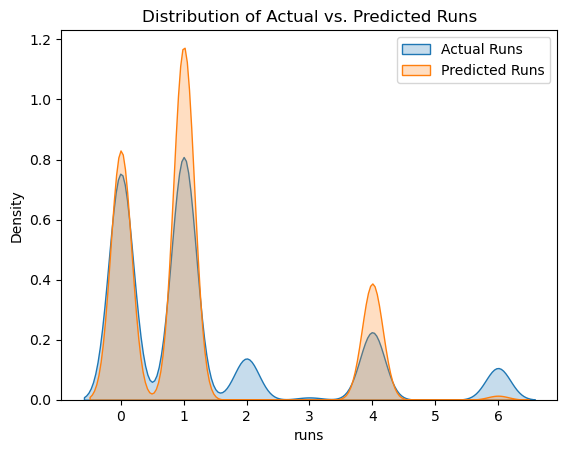

In [201]:
sns.kdeplot(y_test, label='Actual Runs', fill=True)
sns.kdeplot(y_pred, label='Predicted Runs', fill=True)
plt.legend()
plt.title("Distribution of Actual vs. Predicted Runs")
plt.show()

# We have obtained slightly improved results for log loss and roc_auc_score. However, handling data imbalance is still proving to be a challenge

# Lets try oversampling techniques

In [777]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [778]:
print("Class distribution before SMOTE:", Counter(y_train))

Class distribution before SMOTE: Counter({1: 63177, 0: 59980, 4: 17862, 2: 10822, 6: 8136, 3: 628, 5: 26})


In [779]:
smote = SMOTE(sampling_strategy={0: 60000, 1: 63177, 2: 20000, 3:2000, 4:50000, 6:15000, 5:26}, random_state=42)

In [780]:
X_train.fillna(X_train.median(numeric_only=True), inplace=True)

In [781]:
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [557]:
Counter(y_resampled)

Counter({1: 63177, 0: 60000, 4: 50000, 2: 20000, 6: 15000, 3: 2000, 5: 26})

In [558]:
model = xgb.XGBClassifier(
    max_depth=6,
    n_estimators=400,
    learning_rate=0.05,
    objective='multi:softmax',  # Multi-class classification
    random_state=42,
    num_class=7 # Number of categories/classes (adjust as needed)
)

# Train model
model.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred = model.predict(X_test)

In [559]:
accuracy_score(y_test, y_pred)

0.45151650978634394

In [560]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

In [561]:
results_df['Actual'].value_counts()

Actual
1    15924
0    14848
4     4433
2     2709
6     2082
3      152
5       10
Name: count, dtype: int64

In [562]:
results_df['Predicted'].value_counts()

Predicted
1    22240
0    16338
4     1566
6       11
2        3
Name: count, dtype: int64

In [563]:
y_pred_prob = model.predict_proba(X_test)

# Create a DataFrame with the probabilities
probabilities_df = pd.DataFrame(y_pred_prob, columns=[f'Class_{i}' for i in range(7)])

# Add the actual labels to the DataFrame
probabilities_df['Actual'] = y_test.values

In [566]:
probabilities_df

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Actual
0,0.199255,0.464925,0.090920,0.003498,0.160626,0.000585,0.080190,1
1,0.344659,0.272261,0.093162,0.011505,0.190524,0.000022,0.087867,4
2,0.345644,0.454195,0.067306,0.002749,0.074790,0.000025,0.055291,0
3,0.485799,0.189899,0.063160,0.006515,0.153957,0.000011,0.100659,0
4,0.336211,0.455144,0.070984,0.004042,0.065400,0.000013,0.068207,1
...,...,...,...,...,...,...,...,...
40153,0.339644,0.365486,0.065594,0.005772,0.174851,0.000204,0.048450,1
40154,0.206791,0.312284,0.143140,0.005145,0.228011,0.000028,0.104601,1
40155,0.455675,0.376431,0.079236,0.006478,0.066013,0.000011,0.016156,0
40156,0.351319,0.446202,0.070849,0.004261,0.080349,0.000009,0.047011,2


In [564]:
log_loss(y_test, y_pred_prob)

1.3108723654721859

In [565]:
roc_auc_score(y_test, y_pred_prob, multi_class="ovr")

0.6091264372600527

# Slightly improved results after oversampling

# Given the difficulty in predicting exact number of runs scored, it may be a better idea to predict by putting runs into bins - 0-1, 2-3, 4-6

In [743]:
df = pd.read_csv('data.csv')
df['absolute_swing_angle'] = abs(df['swing_angle'])

In [744]:
df = df[df['runs']!=5]

In [745]:
labels = [0, 1, 2]  # Labels for the bins
bins = [-1, 1, 3, 7]
# Step 2: Convert 'runs' into categorical bins
df['runs_binned'] = pd.cut(df['runs'], bins=bins, labels=labels, right=True)

In [746]:
df[df['runs']==4]['runs_binned']

7         2
33        2
36        2
49        2
104       2
         ..
200769    2
200772    2
200773    2
200782    2
200783    2
Name: runs_binned, Length: 22295, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [747]:
target = 'runs'

# Split into train & test (stratify if classification, otherwise just shuffle)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
continuous_cols = df.select_dtypes(include=['number']).columns.tolist()

In [748]:
agg_dfs = []  # Store aggregated DataFrames

# Loop through each categorical column and compute aggregates for all continuous variables
for cat_col in categorical_cols[0:3]:
    agg_df = train_df.groupby(cat_col)[continuous_cols].agg(['mean', 'std']).reset_index()

    # Rename columns using the format categorical_metric_continuous
    agg_df.columns = [f"{cat_col}_{stat}_{col}" if stat else col for col, stat in agg_df.columns]

    # Merge back with train & test data
    train_df = train_df.merge(agg_df, on=cat_col, how='left')
    test_df = test_df.merge(agg_df, on=cat_col, how='left')  # Apply train mappings

    agg_dfs.append(agg_df)  # Store for reference

In [749]:
train_df.drop(['batting_hand','bowling_hand','bowling_type','wicket','runs'],axis=1,inplace=True)
test_df.drop(['batting_hand','bowling_hand','bowling_type','wicket','runs'],axis=1,inplace=True)

In [750]:
train_df

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,...,bowling_type_mean_drop_angle,bowling_type_std_drop_angle,bowling_type_mean_bounce_angle,bowling_type_std_bounce_angle,bowling_type_mean_runs,bowling_type_std_runs,bowling_type_mean_wicket,bowling_type_std_wicket,bowling_type_mean_absolute_swing_angle,bowling_type_std_absolute_swing_angle
0,93.13,-0.25,1.75,-0.35,2.11,-0.15,5.27,0.03,0.52,0.08,...,-15.802796,1.495039,11.263709,2.013999,1.213888,1.566961,0.046169,0.209852,1.197008,0.911241
1,94.38,1.70,-3.64,-0.89,2.05,-0.40,6.13,-0.44,0.69,-0.45,...,-15.802796,1.495039,11.263709,2.013999,1.213888,1.566961,0.046169,0.209852,1.197008,0.911241
2,99.47,1.28,-0.85,-0.82,2.08,0.21,3.58,0.37,0.29,0.46,...,-15.802796,1.495039,11.263709,2.013999,1.213888,1.566961,0.046169,0.209852,1.197008,0.911241
3,87.52,1.63,-1.77,-1.03,2.15,-0.12,5.08,0.09,0.58,0.15,...,-15.802796,1.495039,11.263709,2.013999,1.213888,1.566961,0.046169,0.209852,1.197008,0.911241
4,113.78,0.15,0.60,-0.37,1.89,-0.23,7.82,-0.05,0.75,-0.02,...,-12.807037,2.492796,8.507546,1.772024,1.331289,1.656683,0.052162,0.222356,0.739567,0.751593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160597,136.46,-0.70,0.47,1.22,1.86,0.77,6.83,0.56,0.54,0.51,...,-12.807037,2.492796,8.507546,1.772024,1.331289,1.656683,0.052162,0.222356,0.739567,0.751593
160598,122.26,0.48,-1.83,0.42,1.98,0.25,8.81,-0.10,0.68,-0.16,...,-12.807037,2.492796,8.507546,1.772024,1.331289,1.656683,0.052162,0.222356,0.739567,0.751593
160599,112.34,0.43,-0.47,-0.78,1.95,-0.74,10.38,-0.80,0.90,-0.82,...,-12.807037,2.492796,8.507546,1.772024,1.331289,1.656683,0.052162,0.222356,0.739567,0.751593
160600,104.28,-0.17,2.62,-0.94,2.04,0.05,2.87,0.23,0.37,0.36,...,-12.807037,2.492796,8.507546,1.772024,1.331289,1.656683,0.052162,0.222356,0.739567,0.751593


In [751]:
y_train = train_df.pop('runs_binned')
X_train = train_df.copy()
y_test = test_df.pop('runs_binned')
X_test = test_df.copy()

In [752]:
list(X_train.columns)

['release_speed_kph',
 'swing_angle',
 'deviation',
 'release_position_y',
 'release_position_z',
 'bounce_position_y',
 'bounce_position_x',
 'crease_position_y',
 'crease_position_z',
 'stumps_position_y',
 'stumps_position_z',
 'bounce_velocity_ratio_z',
 'release_angle',
 'drop_angle',
 'bounce_angle',
 'absolute_swing_angle',
 'batting_hand_mean_release_speed_kph',
 'batting_hand_std_release_speed_kph',
 'batting_hand_mean_swing_angle',
 'batting_hand_std_swing_angle',
 'batting_hand_mean_deviation',
 'batting_hand_std_deviation',
 'batting_hand_mean_release_position_y',
 'batting_hand_std_release_position_y',
 'batting_hand_mean_release_position_z',
 'batting_hand_std_release_position_z',
 'batting_hand_mean_bounce_position_y',
 'batting_hand_std_bounce_position_y',
 'batting_hand_mean_bounce_position_x',
 'batting_hand_std_bounce_position_x',
 'batting_hand_mean_crease_position_y',
 'batting_hand_std_crease_position_y',
 'batting_hand_mean_crease_position_z',
 'batting_hand_std_

In [753]:
model = xgb.XGBClassifier(
    max_depth=6,
    n_estimators=400,
    learning_rate=0.05,
    objective='multi:softmax',  # Multi-class classification
    random_state=42,
    num_class=3# Number of categories/classes (adjust as needed)
)

# Train model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

In [754]:
accuracy_score(y_test, y_pred)

0.7630196010062016

In [755]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

In [756]:
results_df['Actual'].value_counts()

Actual
0    30640
2     6565
1     2946
Name: count, dtype: int64

In [757]:
results_df['Predicted'].value_counts()

Predicted
0    40127
2       24
Name: count, dtype: int64

# Unfortuately, we again see that the model is trying to play safe by predicting 0-1 runs for almost the entire set of observations. Let us attempt to try a different algorithm such as neural network

In [784]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [785]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_resampled.shape[1],)),  # Input layer
    layers.Dense(64, activation='relu'),  # Hidden layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(7, activation='softmax')  # Output layer (7 classes)
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy if y is not one-hot encoded
    metrics=['accuracy']
)

# Model summary
model.summary()

C:\Users\Vijay\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,567 (103.78 KB)

 Trainable params: 26,567 (103.78 KB)

 Non-trainable params: 0 (0.00 B)

In [789]:
history = model.fit(
    X_resampled, y_resampled,
    epochs=30,  # Number of epochs (adjust as needed)
    batch_size=64,  # Adjust batch size
    validation_data=(X_test, y_test),  # Use 20% of data for validation
    verbose=1
)

Epoch 1/30
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.3257 - loss: 1.5105 - val_accuracy: 0.3945 - val_loss: 1.4066
Epoch 2/30
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.3298 - loss: 1.5014 - val_accuracy: 0.4132 - val_loss: 1.3989
Epoch 3/30
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.3306 - loss: 1.5017 - val_accuracy: 0.4047 - val_loss: 1.4083
Epoch 4/30
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.3330 - loss: 1.5002 - val_accuracy: 0.4043 - val_loss: 1.3922
Epoch 5/30
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.3337 - loss: 1.4991 - val_accuracy: 0.4166 - val_loss: 1.3964
Epoch 6/30
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.3359 - loss: 1.4987 - val_accuracy: 0.3975 - val_loss: 1.3969
Epoch 7/30
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.3378 - loss: 1.4959 - val_accuracy: 0.3993 - val_loss: 1.4043
Epoch 8/30
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.3388 - loss: 1

# The NN model fails to learn effectively. So finally, lets stick to the XGBoost classification model with weighted samples. We can also go for the model with oversampled data, but the improvement is only marginal. So, going without it may make more sense

# The next notebook contains modelling as well as post-model analysis for better insights